In [24]:
# Install SHAP (only needed once)
!pip install shap --quiet

# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc

import shap
import zipfile
import urllib.request

# Enable inline plots in Colab
%matplotlib inline


In [25]:
# Download and extract the dataset from UCI repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'
urllib.request.urlretrieve(url, 'bank-additional.zip')

with zipfile.ZipFile('bank-additional.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Load CSV with proper separator
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

# Basic inspection
print("Data shape:", df.shape)
print(df.head())


Data shape: (41188, 21)
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

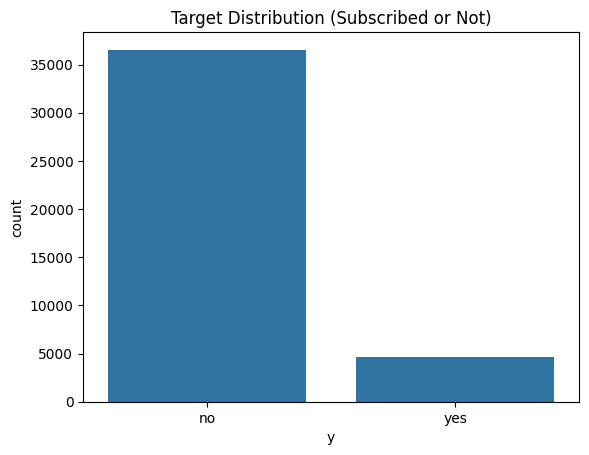

In [26]:
# Info and summary
print(df.info())
print(df.describe())

# Target variable distribution
print(df['y'].value_counts(normalize=True))

# Plot target distribution
sns.countplot(data=df, x='y')
plt.title('Target Distribution (Subscribed or Not)')
plt.show()


In [27]:
# Split features and target
X = df.drop('y', axis=1)
y = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Identify categorical and numeric features
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)

# Preprocessor for OneHotEncoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Numerical columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [28]:
# Logistic Regression pipeline
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
pipe_lr.fit(X_train, y_train)

# Random Forest pipeline
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])
pipe_rf.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('clf', RandomForestClassifier(random_state=42))])


--- Logistic Regression Evaluation ---
Confusion Matrix:
 [[7144  166]
 [ 545  383]]
F1 Score: 0.5186188219363574


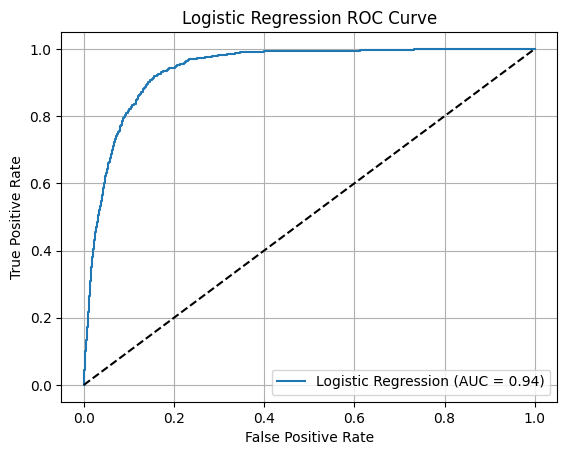


--- Random Forest Evaluation ---
Confusion Matrix:
 [[7129  181]
 [ 488  440]]
F1 Score: 0.5681084570690769


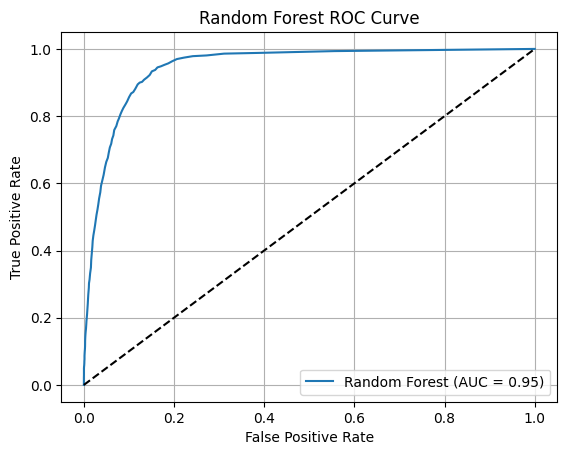

In [29]:
def evaluate_model(pipe, X_test, y_test, model_name):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    print(f"\n--- {model_name} Evaluation ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Evaluate both models
evaluate_model(pipe_lr, X_test, y_test, "Logistic Regression")
evaluate_model(pipe_rf, X_test, y_test, "Random Forest")


In [ ]:
# Preprocess test data manually for SHAP
X_test_preprocessed = pipe_rf.named_steps['preprocessor'].transform(X_test)

# Get feature names after encoding
ohe = pipe_rf.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(ohe_feature_names) + num_cols

# Create SHAP explainer
rf_model = pipe_rf.named_steps['clf']
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_preprocessed)

# Explain top 5 test samples (for class 1: 'yes')
for i in range(5):
    print(f"SHAP explanation for test sample index {i}:")
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[1][i],
        base_values=explainer.expected_value[1],
        data=X_test_preprocessed[i],
        feature_names=all_feature_names
    ))
